### Thinking1
什么是监督学习，无监督学习，半监督学习

答：监督学习：指将已知类别（有标签）的数据作为训练样本来进行机器学习，任务中通常包含有明确的目标（如分类）；  
&emsp;&emsp;无监督学习：指利用类别未知（无标签）的数据来进行学习，进而解决模式识别中的各种问题，其中一个典型例子是聚类；  
&emsp;&emsp;半监督学习：与监督学习的任务一致，区别在于采用的数据既有有标签的也有无标签的，常用于训练数据不充足时，利用没有标签的数据来学习整个数据的潜在分布，提高数据的使用率，提高模型效果。半监督学习算法有图论半监督学习（如标签传播算法），半监督支持向量机等。

### Thinking2
K-means中的k值如何选取

答：K-means常用的评价指标有SEE（误差平方和）和轮廓系数：  
&emsp;&emsp;对于SSE来说，在k值小于真实聚类数时，增大K，SSE的下降程度会很大，而当k值大于真实聚类数时，SSE虽然还是会随着k的增大而减小，但减小的幅度明显减小，所以SSE与k的关系图会呈现手肘的形状，而肘部所对应的转折点就是我们应当选取的k值；  
&emsp;&emsp;对于轮廓系数而言，轮廓系数取值在[-1,1]之间，一个点的轮廓系数越接近于1就说明它越应该被归于现在所归的类，越接近于-1就说明它越应该被归于其他类。所有样本的轮廓系数均值即为聚类结果的轮廓系数。应当选取使轮廓系数较大的k值。

### Thinking3
随机森林采用了bagging集成学习，bagging指的是什么

答：bagging指采用若干个弱学习器，对产生的结果进行投票，从而组成一个强学习器。  
&emsp;&emsp;在随机森林中具体的方式是：若每个样本的特征维度为M，指定训练集大小N和特征数m<<M，训练若干棵决策树，其中每棵树的训练集都是从训练集中随机且有放回地抽取N个样本得到，特征集则是从M个特征中随机选取m个特征。预测时将所有树的分类结果进行投票得到最终结果。

### Thinking4
表征学习和半监督学习的区别是什么

答：表征学习：指通过算法让机器自己学到数据的特征，目的是对复杂的原始数据化繁为简，删除无效信息，更有效地抽取特征；  
&emsp;&emsp;半监督学习：指只有少量数据有标签时，利用无标签数据一起训练，目的是通过无标签数据学习数据的潜在分布，提高模型效果；  
&emsp;&emsp;主动学习：指通过一定的选择策略从未标记样本中挑选出部分样本来进行人工标记（被动学习是随机选择样本的进行人工标记），然后再进行学习，目的是只使用少量的标注数据就能训练得到一个效果较好的分类器，降低人工成本。

### Action1

In [126]:
import pandas as pd
import numpy as np
import jieba

# 数据加载
news = pd.read_csv('sqlResult.csv', encoding='gb18030')

# 数据探索
print(news.shape)
news.head()

(89611, 7)


,id,author,source,content,feature,title,url
0,89617,NaN,快科技@http://www.kkj.cn/,此外，自本周（6月12日）起，除小米手机6等15款机型外，其余机型已暂停更新发布（含开发版/...,"{""type"":""科技"",""site"":""cnbeta"",""commentNum"":""37""...",小米MIUI 9首批机型曝光：共计15款,http://www.cnbeta.com/articles/tech/623597.htm
1,89616,NaN,快科技@http://www.kkj.cn/,骁龙835作为唯一通过Windows 10桌面平台认证的ARM处理器，高通强调，不会因为只考...,"{""type"":""科技"",""site"":""cnbeta"",""commentNum"":""15""...",骁龙835在Windows 10上的性能表现有望改善,http://www.cnbeta.com/articles/tech/623599.htm
2,89615,NaN,快科技@http://www.kkj.cn/,此前的一加3T搭载的是3400mAh电池，DashCharge快充规格为5V/4A。\r\n...,"{""type"":""科技"",""site"":""cnbeta"",""commentNum"":""18""...",一加手机5细节曝光：3300mAh、充半小时用1天,http://www.cnbeta.com/articles/tech/623601.htm
3,89614,NaN,新华社,这是6月18日在葡萄牙中部大佩德罗冈地区拍摄的被森林大火烧毁的汽车。新华社记者张立云摄\r\n,"{""type"":""国际新闻"",""site"":""环球"",""commentNum"":""0"",""j...",葡森林火灾造成至少62人死亡 政府宣布进入紧急状态（组图）,http://world.huanqiu.com/hot/2017-06/10866126....
4,89613,胡淑丽_MN7479,深圳大件事,（原标题：44岁女子跑深圳约会网友被拒，暴雨中裸身奔走……）\r\n@深圳交警微博称：昨日清...,"{""type"":""新闻"",""site"":""网易热门"",""commentNum"":""978"",...",44岁女子约网友被拒暴雨中裸奔 交警为其披衣相随,http://news.163.com/17/0618/00/CN617P3Q0001875...


In [127]:
# 去掉缺失数据
news = news.dropna(subset=['content'])
news.shape

(87054, 7)

In [128]:
# 加载停用词
with open('chinese_stopwords.txt', 'r', encoding='utf-8') as file:
    stopwords = [i[:-1] for i in file.readlines()]
    
# 分词
def split_text(text):
    text = text.replace(' ','').replace('\r\n','')
    text1 = jieba.cut(text)
    result = ' '.join([w for w in text1 if w not in stopwords])
    return result
corpus = list(map(split_text, [str(i) for i in news.content]))
corpus[1]

'骁龙 835 唯一 Windows10 桌面 平台 认证 ARM 处理器 高通 强调 不会 只 考虑 性能 屏蔽掉 小 核心 相反 正 联手 微软 找到 一种 适合 桌面 平台 兼顾 性能 功耗 完美 方案 报道 微软 已经 拿到 一些 源码 Windows10 更好 理解 big little 架构 资料 显示 骁龙 835 一款 集成 CPU GPU 基带 蓝牙 Wi Fi SoC 传统 Wintel 方案 节省 至少 30% PCB 空间 按计划 今年 Q4 华硕 惠普 联想 首发 骁龙 835Win10 电脑 预计 均 二合一 形态 产品 当然 高通 骁龙 未来 也许 见到 三星 Exynos 联发科 华为 麒麟 小米 澎湃 进入 Windows10 桌面 平台'

In [129]:
# 计算TFIDF
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
countvectorizer = CountVectorizer(encoding='gb18030', min_df = 0.015)
tfidftransformer = TfidfTransformer()
count =  countvectorizer.fit_transform(corpus)
tfidf = tfidftransformer.fit_transform(count)
print(tfidf.shape)
tfidf.toarray()

(87054, 884)


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.35722359,
        0.        ]])

In [139]:
# 标记是否为自己的新闻
label = list(map(lambda source: 1 if '新华社' in str(source) else 0, news.source))
label[:5]

[0, 0, 0, 1, 0]

In [140]:
# 数据集切分
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(tfidf.toarray(), label, test_size=0.25, random_state=33)

# 伯努利朴素贝叶斯
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, precision_score, recall_score
model1 = BernoulliNB()
model1.fit(X_train, y_train)
y_predict1 = model1.predict(X_test)
print('伯努利朴素贝叶斯')
print('准确度：', accuracy_score(y_test, y_predict1))
print('精确度：', precision_score(y_test, y_predict1))
print('召回率：', recall_score(y_test, y_predict1))

伯努利朴素贝叶斯
准确度： 0.8273754824480793
精确度： 0.9662011500997536
召回率： 0.8380923296177534


In [141]:
# 多项式朴素贝叶斯
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score
model2 = MultinomialNB()
model2.fit(X_train, y_train)
y_predict2 = model2.predict(X_test)
print('多项式朴素贝叶斯')
print('准确度：', accuracy_score(y_test, y_predict2))
print('精确度：', precision_score(y_test, y_predict2))
print('召回率：', recall_score(y_test, y_predict2))

多项式朴素贝叶斯
准确度： 0.8869693071126631
精确度： 0.9618423174074273
召回率： 0.9109278770295719


In [135]:
# 高斯朴素贝叶斯
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score
model3 = GaussianNB()
model3.fit(X_train, y_train)
y_predict3 = model3.predict(X_test)
print('高斯朴素贝叶斯')
print('准确度：', accuracy_score(y_test, y_predict3))
print('精确度：', precision_score(y_test, y_predict3))
print('召回率：', recall_score(y_test, y_predict3))

高斯朴素贝叶斯
准确度： 0.8252619003859585
精确度： 0.9924779311202288
召回率： 0.8125922532702193


In [175]:
# 选择多项式贝叶斯作为模型
model = model2
prediction = model.predict(tfidf.toarray())
labels = np.array(label)

# 将预测值与真实值进行拼接
compare = pd.DataFrame({'prediction':prediction, 'label':labels})
print(compare.head())

# 实际为新华社的文章
xinhuashe = compare[compare['label']==1].index

# 找出怀疑对象，即预测值为1，标签为0的项
doubt = compare[(compare['prediction']==1)&(compare['label']==0)].index
doubt

   prediction  label
0           0      0
1           0      0
2           0      0
3           1      1
4           1      0


Int64Index([   4,   24,   25,   28,   30,   35,   37,   38,   43,   45,
            ...
            8534, 8535, 8538, 8539, 8543, 8546, 8548, 8549, 8551, 8552],
           dtype='int64', length=2812)

In [147]:
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# 数据标准化
normalizer = Normalizer()
scaled_array = normalizer.fit_transform(tfidf.toarray())

# 寻找合适的k值
Kmeans = []
SSE = []
Silhouette = []
for k in range(10,30):
    kmeans = KMeans(n_clusters=k)
    k_labels = kmeans.fit_predict(scaled_array)
    silhouette = silhouette_score(scaled_array, k_labels)
    Kmeans.append(kmeans)
    SSE.append(kmeans.inertia_)
    Silhouette.append(silhouette)
    
print(SSE)
print(Silhouette)

[71154.09701930192, 70872.68999907238, 70494.3591034558, 70152.5386213468, 69668.73552073102, 69077.52648226419, 68940.43345688612, 68677.02324135807, 68378.36934836578, 67996.13166669222, 67602.28774406409, 67486.74009723481, 67033.83023750359, 66847.26476753972, 66628.17062338424, 66400.97742147384, 66141.01214901615, 65972.77571073029, 65822.36749522705, 65618.21472479298]
[0.0401026387145753, 0.035688568627789935, 0.03986609143514819, 0.04618242283155071, 0.04822752185133264, 0.05003675367732157, 0.045552410719411816, 0.047055366480988015, 0.05001416803502926, 0.044668468876771714, 0.05601813781765829, 0.05271786974546279, 0.05578602482713971, 0.055599569452264366, 0.056806889641965584, 0.05032547138764415, 0.05946020109482276, 0.05856008416471299, 0.05552534809353279, 0.06127054167888914]


<function matplotlib.pyplot.show(*args, **kw)>

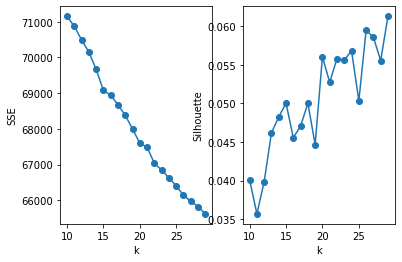

In [153]:
X = range(10,30)
plt.figure()
plt.subplot(121)
plt.xlabel('k')
plt.ylabel('SSE')
plt.plot(X, SSE, '-o')
plt.subplot(122)
plt.xlabel('k')
plt.ylabel('Silhouette')
plt.plot(X, Silhouette, '-o')
plt.show

In [161]:
# 选择k=26
kmeans = Kmeans[16]
k_labels = kmeans.fit_predict(scaled_array)

from collections import defaultdict

#创建id_class对应字典
id_class = {i:_class for i,_class in enumerate(k_labels)}

# 将新华社的文章归到相应的类中
class_id = defaultdict(set)
for id in xinhuashe:
    class_id[id_class[id]].add(id)

In [200]:
# 在疑似文章所属类中,计算与新华社文章的相似度并排序，从而找到相似度TopN的文章
from sklearn.metrics.pairwise import cosine_similarity
def find_similar(cpindex, top=10):
    dis_dic = {i:cosine_similarity(tfidf[cpindex],tfidf[i])[0][0] for i in class_id[id_class[cpindex]]}
    return sorted(dis_dic.items(), key=lambda x: x[1], reverse=True)[:top]

# 创建字典查询，并对疑似文章中index='4'的文章进行查询
temp = {}
for i in doubt:
    temp[str(i)] = pd.DataFrame(find_similar(i),columns=['similar_index','similarity'])
temp['4']

,similar_index,similarity
0,50852,0.858142
1,50720,0.852157
2,86497,0.782699
3,67073,0.738660
4,12505,0.703209
5,40457,0.696689
6,9008,0.632713
7,13155,0.630622
8,73984,0.610875
9,48190,0.604728


In [177]:
news.iloc[4].content

'（原标题：44岁女子跑深圳约会网友被拒，暴雨中裸身奔走……）\r\n@深圳交警微博称：昨日清晨交警发现有一女子赤裸上身，行走在南坪快速上，期间还起了轻生年头，一辅警发现后赶紧为其披上黄衣，并一路劝说她。\r\n那么事发时\r\n到底都发生了些什么呢？\r\n南都记者带您一起还原现场\r\n南都记者在龙岗大队坂田中队见到了辅警刘青（发现女生的辅警），一位外表高大帅气，说话略带些腼腆的90后青年。\r\n刘青介绍，6月16日早上7时36分，他正在环城南路附近值勤，接到中队关于一位女子裸身进入机动车可能有危险的警情，随后骑着小铁骑开始沿路寻找，大概花了十多分钟在南坪大道坂田出口往龙岗方向的逆行辅道上发现该女子。\r\n女子身上一丝不挂地逆车流而行，时走时停，时坐时躺，险象环生。刘青停好小铁骑，和另外一名巡防员追了上去，发现女子的情绪很低落，话不多，刘青尝试和女子交流，劝说女子离开，可女子并不愿意接受，继续缓慢地往南坪快速路的主干道上走去。\r\n此时路边上已经聚集了很市民围观，为了不刺激女子的情绪，刘青和巡防员一边盯着女子一边驱赶着围观的群众。\r\n现场还原\r\n从警方提供的一份视频了解到，16日早上7时25分，女子出现在坂雪岗大道与环城南路的监控视频中，此时女子还穿着白色的内裤，正沿着坂雪岗大道往南坪快速的方向缓慢地走着。\r\n当时正值上班高峰期，十字路口的车流已经排起了长队。当女子出现时，路上的市民纷纷驻足观望，不少车辆也放慢了速度，但女子并不为市民观望停下脚步，依然缓慢走着。当女子行进到十字路口中间时，一辆大货车挡住了镜头，但是当女子再次出现镜头时，可以发现女子已经没穿内裤了，全身裸露继续朝着南坪快速方向走去。记者发现，视频中女子周围并没有人尾随或者上前劝止的市民。\r\n一大清早路上看到这样的情况\r\n恐怕大家都没办法淡定\r\n面对这一情况\r\n刘青表示，“一开始根本不敢看她，心里挺别扭，感觉很尴尬”，但当刘青跟随女子上了南坪快速路主干道时，女子作出了让人意想不到的举动，她突然靠近护栏要从上面跳下去，刘青赶忙冲上去拉住了女子的手，将其控制住并远离护栏。碍于女子没有穿衣服，刘青递上衣服，女子没接受还把衣服扔到排水沟里，继续往前走，没办法刘青只能紧紧拉着她的一只手跟在后面。\r\n刘青一路上耐心地开导安慰她，但只听到她不断地重复着一句话“要是你也遭遇我的

In [201]:
news.iloc[50852].content

'新华社合肥5月7日电（记者陈尚营）15楼是什么概念？大约45米高，一般人向下看都会觉得害怕。5月6日，在安徽芜湖，一位消防官兵仅凭一根安全绳，在15楼走“独木桥”救下一名女子。\\n芜湖市消防支队相关人士介绍，6日早上，芜湖市大桥镇一小区内，一女子坐在15楼阳台旁的横梁上，想要跳楼轻生。一名消防官兵悄悄通过放置空调外机处空出来的仅10余厘米宽、2米多长的边沿，成功将女子救下。\\n\u3000\u3000（视频截图）\\n消防官兵到达现场时，一名年轻女子在15楼阳台旁的横梁上，左手扶着阳台栏杆，右手拿着手机，不断哭诉。为防止女子意外跌落，消防官兵首先在楼下铺设救生气垫。随后，几名官兵来到15楼，一边联合物业人员对女子进行劝解，一边与现场民警一起研究营救方案。\\n在与现场民警协商后，大家决定一边继续劝解女子，吸引她的注意力。同时由一名消防官兵系好安全绳悄悄从后方慢慢接近女子。女子的后方是一个空调外机放置处，堆满了杂物，为了不发出声音惊扰到女子，消防官兵只好从外机放置处仅10余厘米宽、2米多长的边沿慢慢接近女子，趁其不备从后面将其抱住，和临近阳台的其他官兵一起将其救下。\\n据了解，女子今年20多岁，有一个儿子，因与丈夫吵架一时想不开，才想要跳楼轻生。\\n'